In [4]:
import numpy as np
import pandas as pd
import json

In [5]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

# DATA LOADING

In [6]:
def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def load_hist_quote_data(files):
    md = [pd.read_csv(f,sep=';') for f in files]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['profit_and_loss'], inplace=True)
    rename_columns = {'product':'symbol', 'bid_price_1': 'bid', 'ask_price_1': 'ask', 
                      'bid_volume_1':'bid_sz', 'ask_volume_1': 'ask_sz', 
                      'bid_price_2':'bid_2','bid_volume_2':'bid_sz_2','ask_price_2':'ask_2','ask_volume_2':'ask_sz_2',
                      'bid_price_3':'bid_3','bid_volume_3':'bid_sz_3','ask_price_3':'ask_3','ask_volume_3':'ask_sz_3'}
    md.rename(columns=rename_columns, inplace=True)
    for i in [4, 5]:
        for col in ['bid','ask']:
            md[f'{col}_{i}'] = np.nan
            md[f'{col}_sz_{i}'] = np.nan

    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def load_hist_trade_data(files,hist_days):
    md = [pd.read_csv(f,sep=';') for f in files]
    for i in range(len(hist_days)):
        md[i]['day'] = hist_days[i]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['buyer', 'seller'], inplace=True)
    md = md[md.price > 0].copy()
    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets

def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    Experimental - NOT SURE IF THIS IS GOING TO BE HELPFUL
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

def combine_hist_quote_trades(hist_quotes, hist_trades):
    """ Join data frames together
    """
    for sym in SYMBOLS:
        quotes = hist_quotes[sym]
        trades = hist_trades[sym]
        # Join quote data to trades
        trades = trades.merge(quotes, how='left', on=['symbol','day','timestamp'])
        trades['notional'] = trades['price']*trades['quantity']

        augment_trade_data(trades)
        trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
        trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
        trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
        
        # Summarize state by state trade data
        trades_grp = trades.groupby(['symbol','day','timestamp']).agg({
            'quantity':'sum', 'notional':'sum', 'buy_vol':'sum', 'sell_vol':'sum','grey_vol':'sum'})
        
        trades_grp['vwap'] = trades_grp['notional']/trades_grp['quantity']
        trades_grp['trades'] = trades.groupby(['symbol','day','timestamp']).size()
        trades_grp = trades_grp.rename(columns={'quantity':'volume'})
        
        # Join trade data to quote
        quotes = quotes.merge(trades_grp.reset_index(), how='left')
        for col in ['volume', 'notional','trades', 'buy_vol','sell_vol','grey_vol']:
            quotes[col].fillna(0, inplace=True)
        quotes['vwap'].fillna(method='ffill',inplace=True)
        quotes.loc[quotes.vwap.isna(), 'vwap'] = quotes.loc[quotes.vwap.isna(), 'mid_price']
        
        # Update
        hist_quotes[sym] = quotes
        hist_trades[sym] = trades.copy()
    
    return hist_quotes, hist_trades

def load_hist_data(quote_files, trade_files, hist_days):
    hist_quotes = load_hist_quote_data(quote_files)
    hist_trades = load_hist_trade_data(trade_files, hist_days)
    
    hist_quotes, hist_trades = combine_hist_quote_trades(hist_quotes, hist_trades)
    return hist_quotes, hist_trades

In [10]:
fig_size = (6,3)

def plot_col_sym(md, sym, col):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", col, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.set_title(sym)
    plt.tight_layout()
    return

# Round 2

In [14]:
data_dir = 'hist_data/island-data-bottle-round-2/'
hist_days = [-1, 0, 1]
quote_files = [f'{data_dir}prices_round_2_day_{i}.csv' for i in hist_days]
trade_files = [f'{data_dir}trades_round_2_day_{i}_nn.csv' for i in hist_days]

hist_quotes2, hist_trades2 = load_hist_data(quote_files, trade_files, hist_days)
# for sym in SYMBOLS:
#     hist_quotes[sym] = quote_preprocess(hist_quotes[sym])

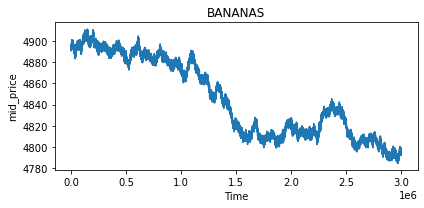

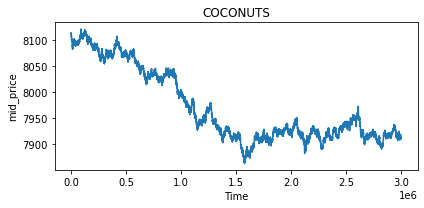

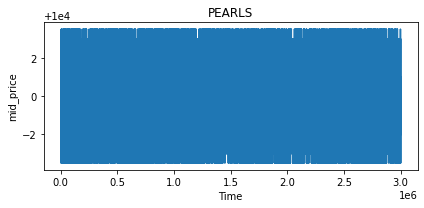

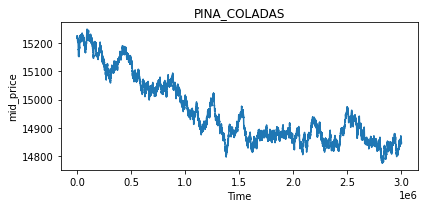

In [15]:
for sym in hist_quotes2:
    quote = hist_quotes[sym]
    plot_col_sym(quote, sym, 'mid_price')

# Round 3

In [16]:
data_dir = 'hist_data/island-data-bottle-round-3/'
hist_days = [0, 1, 2]
quote_files = [f'{data_dir}prices_round_3_day_{i}.csv' for i in hist_days]
trade_files = [f'{data_dir}trades_round_3_day_{i}_nn.csv' for i in hist_days]

hist_quotes3, hist_trades3 = load_hist_data(quote_files, trade_files, hist_days)

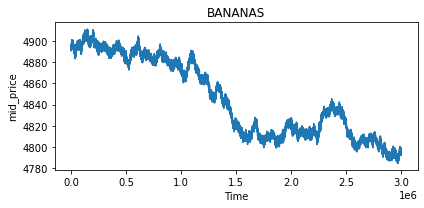

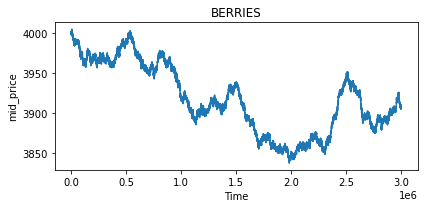

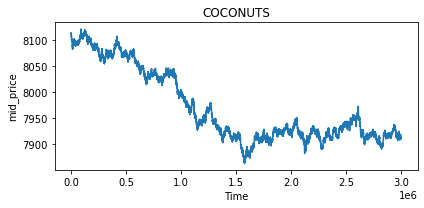

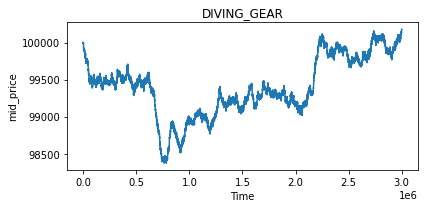

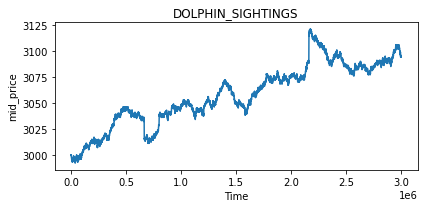

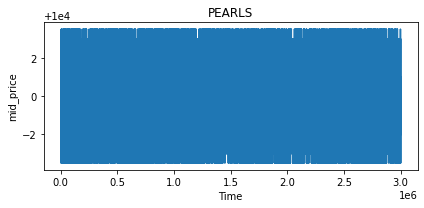

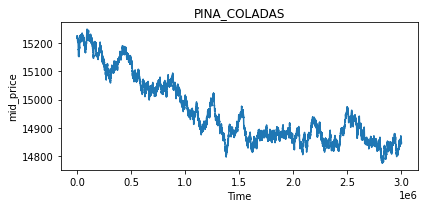

In [17]:
for sym in hist_quotes3:
    quote = hist_quotes3[sym]
    plot_col_sym(quote, sym, 'mid_price')

# Test

In [18]:
banana_r2 = hist_quotes2['BANANAS']
banana_r3 = hist_quotes3['BANANAS']

<AxesSubplot:>

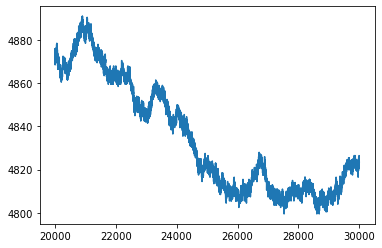

In [20]:
banana_r2.loc[banana_r2.day == 1]['mid_price'].plot()

<AxesSubplot:>

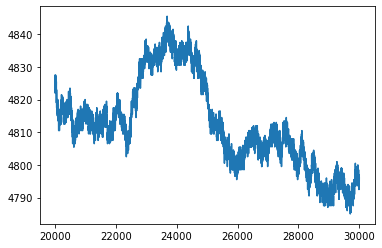

In [22]:
banana_r3.loc[banana_r3.day == 2]['mid_price'].plot()